### 1996 American National Election Survey

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from hiveplotlib import p2cp_n_axes
from hiveplotlib.viz import p2cp_legend, p2cp_viz

In 1996, Democratic Party nominee Bill Clinton defeated Republican Party nominee Bob Dole in the [United States Presidential Election](https://en.wikipedia.org/wiki/1996_United_States_presidential_election). Around the time of the election, the [American National Election Studies](https://electionstudies.org/) conducted a survey of voters that year to explore several behavioral and socioeconomic factors in conjunction with voting behavior.

In this notebook, we'll perform a multidimensional exploration of data from the 1996 American National Election Survey with one figure of multiple Polar Parallel Coordinates Plots (P2CPs).

#### The Data

We will use a subset of the 1996 survey data, pulling our dataset directly from the `statsmodels` python package repository. This subset contains 944 voters with 10 variables of data. Note, this subset contains no missing values.

For more information on what variables were included in the subset, or what each of the categorical variable values represent, see the metadata in the [statsmodels documentation](https://www.statsmodels.org/stable/datasets/generated/anes96.html).

In [2]:
# pull data directly from Github to avoid another dependency
anes96_path = (
    "https://raw.githubusercontent.com/"
    + "statsmodels/statsmodels/main/statsmodels/datasets/anes96/anes96.csv"
)

df = pd.read_csv(anes96_path, engine="python", sep=r"\s")

# drop the extra ' values around the str column names
df.columns = [n.replace("'", "") for n in df.columns.to_numpy()]

# store indices for later
# df = df.reset_index(names="unique_id")

df

popul  TVnews  selfLR  ClinLR  DoleLR  PID  age  educ  income  vote
0        0       7       7       1       6    6   36     3       1     1
1      190       1       3       3       5    1   20     4       1     0
2       31       7       2       2       6    1   24     6       1     0
3       83       4       3       4       5    1   28     6       1     0
4      640       7       5       6       4    0   68     6       1     0
..     ...     ...     ...     ...     ...  ...  ...   ...     ...   ...
939      0       7       7       1       6    4   73     6      24     1
940      0       7       5       2       6    6   50     6      24     1
941      0       3       6       2       7    5   43     6      24     1
942      0       6       6       2       5    6   46     7      24     1
943     18       7       4       2       6    3   61     7      24     1

[944 rows x 10 columns]

#### Exploratory Visualization

Our visualization will simultaneously explore 5 of the 10 variables.

We will generate P2CPs by first breaking up our data by whether the respondents voted for Clinton or Dole.

We will next break up the data based on each respondent's party identification, spanning from saturated blue <font color='blue' style="font-weight:bold">Strong Democrat</font> to gray <font color='darkgray' style="font-weight:bold">Independent</font> to saturated red <font color='red' style="font-weight:bold">Strong Republican</font>, with less saturated blues and reds for the more politically moderate groups in between.

Each P2CP will look at the trivariate relationship between:

* Education - a categorical representation from `8th grade education or lower` up to `PhD`.
* Age - measured in years.
* Income - a categorical binning of incomes starting from `$0-$2999` up to `$105,000 and over`.

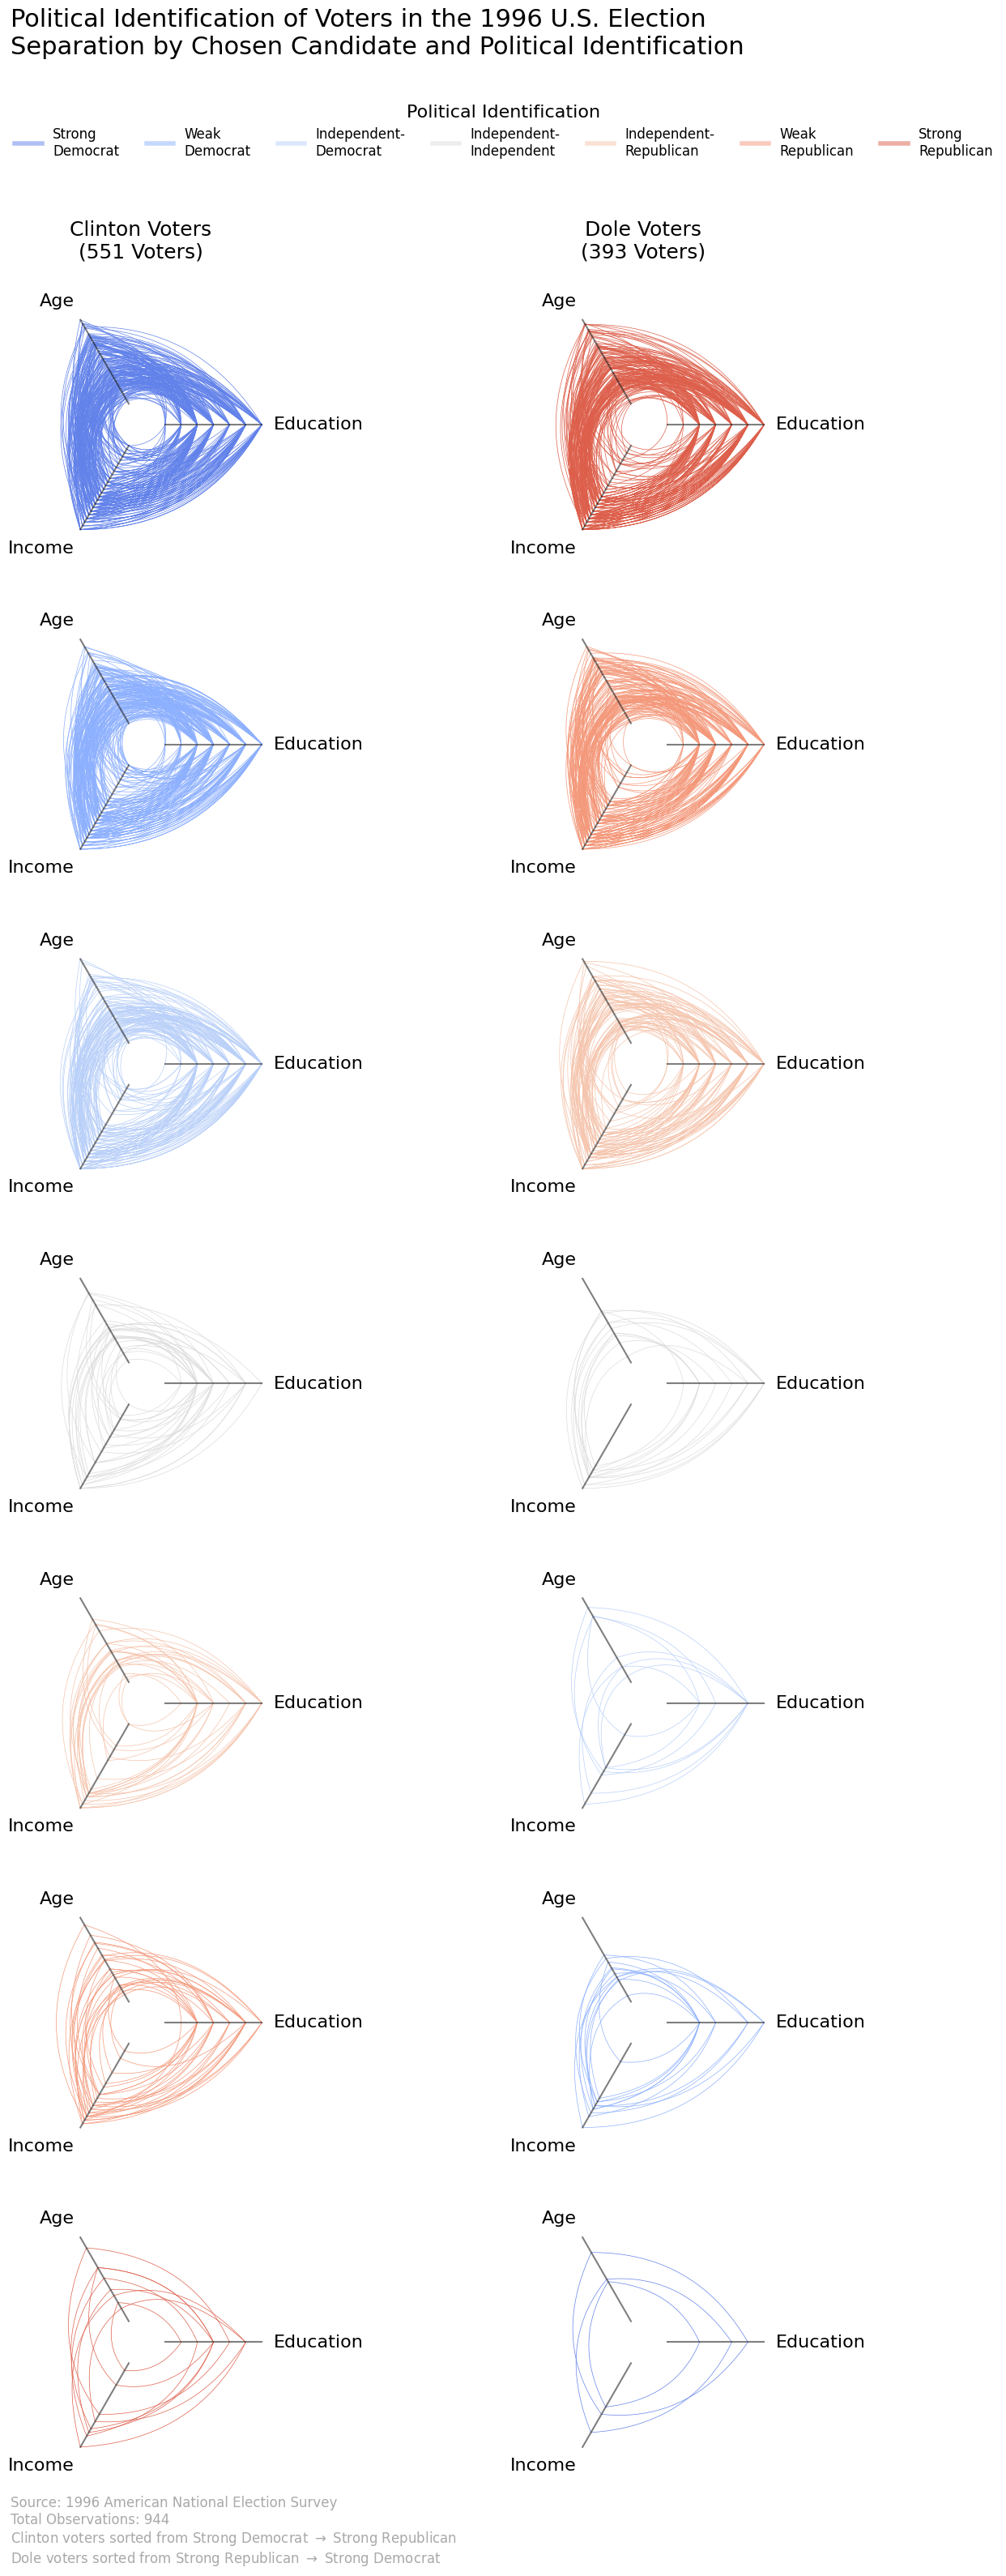

In [3]:
# we will color lines by Political Identification
color_col = "PID"

# 1 color per unique Political ID
#  (colormap chosen to correspond to blue=dem, red=rep norms)
num_colors = df[color_col].unique().size
colors = sns.color_palette("coolwarm", n_colors=num_colors)

# rename columns to use
#  (to make the axes names more readable in final figure)
df = df.rename(columns={"educ": "Education", "age": "Age", "income": "Income"})

# our axes of choice
cols = ["Education", "Age", "Income"]

# we will first split survey data into two groups
#  based on who was voted for
multi_figure_col = "vote"

# generate one dataframe per voting group
#  only keeping the columns to plot plus the coloring column
dfs = [
    df.loc[df[multi_figure_col] == i, cols + [color_col]]
    for i in sorted(df[multi_figure_col].unique())
]

# we will fix all of the axes on each P2CP to the same vmin, vmax
mins = df.loc[:, cols].min(axis=0)
maxes = df.loc[:, cols].max(axis=0)

# corresponding candidates to the "vote" dummy variable values
titles = ["Clinton Voters", "Dole Voters"]

fig, axes = plt.subplots(num_colors, 2, figsize=(6 * 2, 5 * num_colors))

for i in range(2):
    for j in range(num_colors):
        # draw dem -> rep for Clinton, rep -> dem for Dole
        #  (makes each column go most votes -> least votes)
        ax = axes[j, i] if i == 0 else axes[num_colors - 1 - j, i]

        # subset df for one voter choice, one political identification
        #  keeping only the columns we want to plot as axes
        df_vote_pid = dfs[i][dfs[i].PID.to_numpy() == j].loc[:, cols]

        # build and visualize P2CP
        p2cp = p2cp_n_axes(
            df_vote_pid,
            vmins=mins,
            vmaxes=maxes,
            all_edge_kwargs={"lw": 0.5, "alpha": 1, "color": colors[j]},
        )
        p2cp_viz(p2cp, fig=fig, ax=ax, node_kwargs={"color": "none"})

        # put a figure title only on the top of each column
        if (j == 0 and i == 0) or (j == 6 and i == 1):
            ax.set_title(f"{titles[i]}\n({dfs[i].shape[0]} Voters)", size=18, y=1.1)

# add some space between the two columns
fig.subplots_adjust(wspace=1)

# nice legend labels, pulled out of statsmodels documentation
legend_labels = [
    "Strong\nDemocrat",
    "Weak\nDemocrat",
    "Independent-\nDemocrat",
    "Independent-\nIndependent",
    "Independent-\nRepublican",
    "Weak\nRepublican",
    "Strong\nRepublican",
]
# make a p2cp with all the groups to use api tools to quickly build the legend
p2cp_with_legend = p2cp_n_axes(
    dfs[i],
    split_on=color_col,
    all_edge_kwargs={"lw": 1.5, "alpha": 0.5},
    indices_list_kwargs=[{"color": i} for i in colors],
)
p2cp_legend(
    p2cp_with_legend,
    fig,
    ax,
    line_kwargs={"lw": 4},
    title="Political Identification",
    labels=legend_labels,
    bbox_to_anchor=(-2.05, 1.75),
    ncol=len(legend_labels),
    prop={"size": 12},
    title_fontsize=16,
    frameon=False,
)

fig.suptitle(
    "Political Identification of Voters in the 1996 U.S. Election\n"
    "Separation by Chosen Candidate and Political Identification",
    y=0.98,
    size=22,
    ha="left",
    x=0.12,
)

caption = (
    "Source: 1996 American National Election Survey\n"
    + "Total Observations: 944\n"
    + "Clinton voters sorted from "
    + "Strong Democrat $\\rightarrow$ Strong Republican\n"
    + "Dole voters sorted from "
    + "Strong Republican $\\rightarrow$ Strong Democrat"
)
plt.figtext(
    0.12,
    0.08,
    caption,
    wrap=True,
    horizontalalignment="left",
    fontsize=12,
    color="darkgray",
)

plt.show()

#### Observations

Before discussing any patterns of the P2CP curves, we can see from the _number_ of curves amongst these P2CPs that a big part of Clinton's victory over Dole stems from Clinton's relative success in getting Independents and moderate Republicans to vote for him.


Let's first mention some _univariate_ observations from these figures:

* Incomes tend to skew higher for Republican voters.
* All ages seem to be similarly covered by both parties, but both independents and groups voting against their identified party tend to skew younger.
* Education levels seem comparable between rows of P2CPs.

Next, let's discuss any _bivariate_ observations of note:

* Income and age tend to be positively correlated, though there appears to be a heterogeneous pattern of some of the oldest people being in the lowest-income groups.
* Income and education tend to be positively correlated.
* There's perhaps a slight negative correlation between Age and Education

Finally, let's discuss some _trivariate_ observations:

* Independents who voted for Dole were predominantly young, high-income, and of varying education levels, while Clinton-voting independents had no particular pattern on age, income, and education.
* Independent-Republicans who voted for Clinton were comparable to Independent-Republican Dole voters, with the exception of skewing toward higher income levels.
* Weak Democrats who voted for Clinton spanned all ages, incomes, and education levels, while Dole-voting Weak Democrats tended to be young, high-income, with a somewhat bimodal distribution of education levels.